# MachineMax Technical Test - Model Building

## Imports

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, auc, classification_report
from xgboost import XGBClassifier
from Codebase.models import TimeSeriesModelEvaluator
from Codebase.statistical_models import EngineStatePredictor
import shap

ImportError: cannot import name 'EngineStatePredictor' from 'Codebase.statistical_models' (c:\Users\Danie\Desktop\MachineMax Tech_Test\Codebase\statistical_models.py)

## Loading Data

In [2]:
df = pd.read_csv('./data/time-series1.csv')

## Preprocessing Data

In [3]:
# Convert the timestamp to a numerical value
df['timestamp_asint'] = pd.to_datetime(df['timestamp']).astype('int64')

df.head()

,rms,state,timestamp,timestamp_asint
0,0.236160,States.OFF,2021-01-01 00:00:00,1609459200000000000
1,1.485381,States.OFF,2021-01-01 00:00:10,1609459210000000000
2,1.128444,States.OFF,2021-01-01 00:00:20,1609459220000000000
3,1.190676,States.OFF,2021-01-01 00:00:30,1609459230000000000
4,1.441717,States.OFF,2021-01-01 00:00:40,1609459240000000000


In [4]:
# Encode the categorical state variable using one-hot encoding
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(df[['state']])
df[['States.ACTIVE', 'States.IDLE', 'States.OFF']] = y_encoded.toarray().astype(int)
df['state_encoded'] = np.argmax(y_encoded, axis=1)

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
df[['timestamp_scaled', 'rms_scaled']] = scaler.fit_transform(df[['timestamp_asint', 'rms']])

In [6]:
df.columns = df.columns.map(str)
df.head(200)

,rms,state,timestamp,timestamp_asint,States.ACTIVE,States.IDLE,States.OFF,state_encoded,timestamp_scaled,rms_scaled
0,0.236160,States.OFF,2021-01-01 00:00:00,1609459200000000000,0,0,1,2,0.000000,0.000263
1,1.485381,States.OFF,2021-01-01 00:00:10,1609459210000000000,0,0,1,2,0.001346,0.001721
2,1.128444,States.OFF,2021-01-01 00:00:20,1609459220000000000,0,0,1,2,0.002692,0.001304
3,1.190676,States.OFF,2021-01-01 00:00:30,1609459230000000000,0,0,1,2,0.004038,0.001377
4,1.441717,States.OFF,2021-01-01 00:00:40,1609459240000000000,0,0,1,2,0.005384,0.001670
...,...,...,...,...,...,...,...,...,...,...
195,506.705862,States.ACTIVE,2021-01-01 00:32:30,1609461150000000000,1,0,0,0,0.262450,0.591398
196,466.630940,States.ACTIVE,2021-01-01 00:32:40,1609461160000000000,1,0,0,0,0.263795,0.544624
197,547.582753,States.ACTIVE,2021-01-01 00:32:50,1609461170000000000,1,0,0,0,0.265141,0.639108
198,587.969861,States.ACTIVE,2021-01-01 00:33:00,1609461180000000000,1,0,0,0,0.266487,0.686247


# Model Building

## Metrics Used:
- **Accuracy**: The proportion of true results (both true positives and true negatives) among the total number of cases examined. It measures the overall performance of the model.

- **Precision**: The proportion of true positives among the total number of positive results (true positives and false positives). It measures the ability of the model to correctly identify positive cases.

- **Recall**: The proportion of true positives among the total number of actual positive cases (true positives and false negatives). It measures the ability of the model to correctly identify all positive cases.

- **F1 score**: The harmonic mean of precision and recall. It provides a single score that balances both precision and recall.

- **Confusion matrix**: A table that summarizes the performance of a classification model by comparing predicted and actual values. It shows the number of true positives, false positives, true negatives, and false negatives.

## Statistical Models

### Rolling Window Slope Estimation
This code calculates the slope of the 'rms' column of the dataframe using a rolling window of size 10. It then creates a new column 'engine_state' based on the slope value. If the slope is positive, the engine state is set to 0 (ACTIVE), otherwise it is set to 1 (IDLE). Additionally, if the 'rms' value is less than 2, the engine state is set to 2 (which represents 'OFF'). The function `calculate_slope` uses linear regression to calculate the slope of the series.

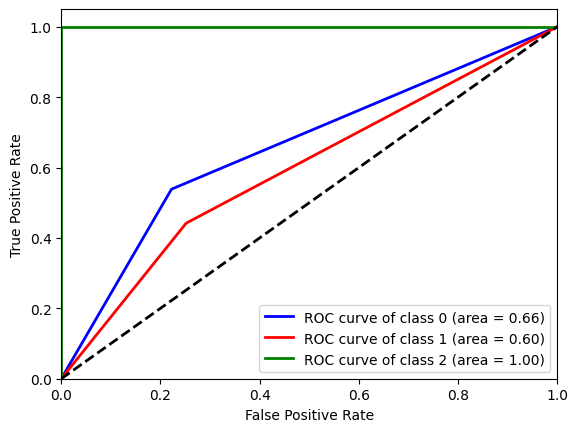

accuracy: 
0.6774193548387096
precision: 
0.6606060606060606
recall: 
0.6601073345259392
f1_score: 
0.6570294784580498
confusion_matrix: 
[[168 144   0]
 [ 96  76   0]
 [  0   0 260]]
classification_report: 
              precision    recall  f1-score   support

           0       0.64      0.54      0.58       312
           1       0.35      0.44      0.39       172
           2       1.00      1.00      1.00       260

    accuracy                           0.68       744
   macro avg       0.66      0.66      0.66       744
weighted avg       0.70      0.68      0.68       744



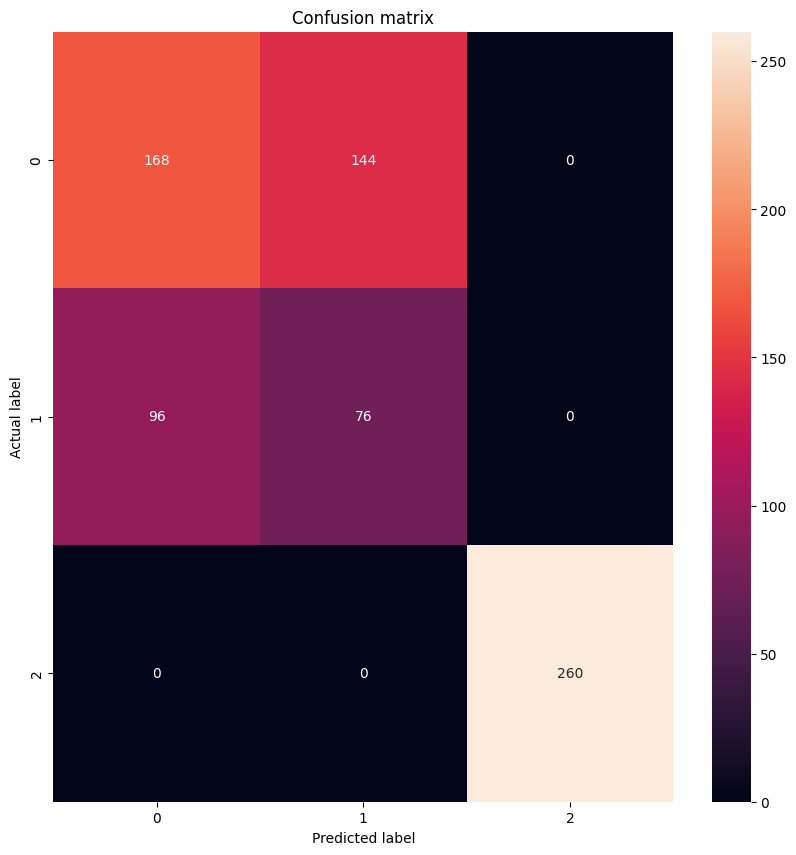

In [7]:
df['engine_state'], metrics = predict(
    df
)
for key, value in metrics.items():
    print(f'{key}: \n{value}')

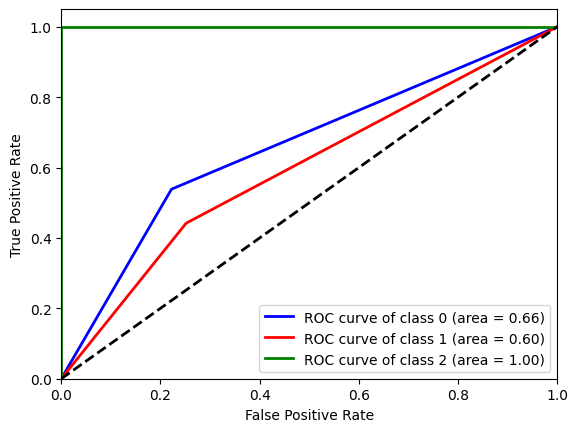

In [9]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# assume y_true is an array of true class labels and y_pred is an array of predicted probabilities for each class
# binarize the true class labels
y_true = label_binarize(df['state_encoded'], classes=[0, 1, 2])
y_pred = label_binarize(df['engine_state'], classes=[0, 1, 2])

n_classes = 3
# calculate the ROC curve and AUC score for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plot the ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

# plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# set the plot properties
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [10]:
metrics = {
            'accuracy': accuracy_score(df['state_encoded'], df['engine_state']),
            'precision': precision_score(df['state_encoded'], df['engine_state'], average='macro', zero_division=0),
            'recall': recall_score(df['state_encoded'], df['engine_state'], average='macro', zero_division=0),
            'f1_score': f1_score(df['state_encoded'], df['engine_state'], average='macro'),
            'confusion_matrix': confusion_matrix(df['state_encoded'], df['engine_state']),
            'classification_report': classification_report(df['state_encoded'], df['engine_state'])
}
# print the metrics
for key, value in metrics.items():
    print(f"{key}: \n{value}\n")

accuracy: 
0.6774193548387096

precision: 
0.6606060606060606

recall: 
0.6601073345259392

f1_score: 
0.6570294784580498

confusion_matrix: 
[[168 144   0]
 [ 96  76   0]
 [  0   0 260]]

classification_report: 
              precision    recall  f1-score   support

           0       0.64      0.54      0.58       312
           1       0.35      0.44      0.39       172
           2       1.00      1.00      1.00       260

    accuracy                           0.68       744
   macro avg       0.66      0.66      0.66       744
weighted avg       0.70      0.68      0.68       744




In [ ]:
from statsmodels.tsa.stattools import adfuller
# Perform Augmented Dickey-Fuller test:
print('Results of Augmented Dickey-Fuller Test:')
dftest = adfuller(df['rms'], autolag='AIC')  # change 'vibration' to your column name

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value

print(dfoutput)

Results of Augmented Dickey-Fuller Test:
Test Statistic                  -1.959854
p-value                          0.304448
#Lags Used                       6.000000
Number of Observations Used    737.000000
Critical Value (1%)             -3.439254
Critical Value (5%)             -2.865470
Critical Value (10%)            -2.568863
dtype: float64


## Machine-Learning Models
Data will be split using TimeSeriesSplit or train_test_split (taking the last 25% as the test data
)
### Logistic Regression

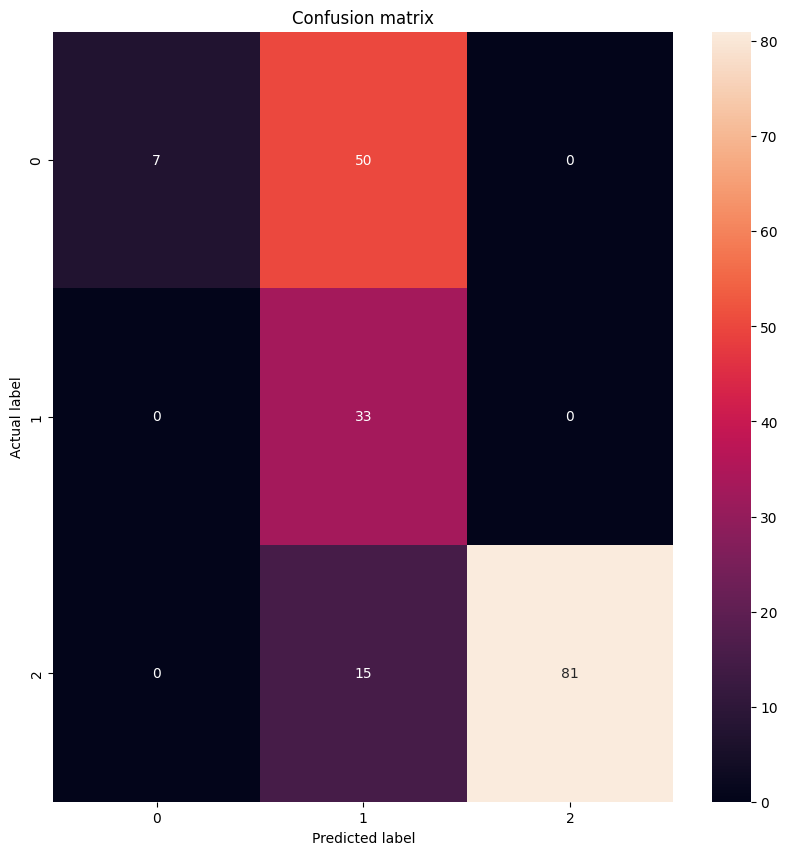

In [ ]:
# Train a logistic regression model
model = LogisticRegression()

evaluator = TimeSeriesModelEvaluator(model)

LR_metrics = evaluator.evaluate(
    X=df[['timestamp_scaled', 'rms_scaled']].values,
    y=df['state_encoded'].values
)

In [ ]:
# print the metrics
for key, value in LR_metrics.items():
    print(f"{key}: \n{value}\n")

accuracy: 
0.6505376344086021

precision: 
0.7789115646258503

recall: 
0.6555190058479532

f1_score: 
0.5459403437270884

confusion_matrix: 
[[ 7 50  0]
 [ 0 33  0]
 [ 0 15 81]]

classification_report: 
              precision    recall  f1-score   support

           0       1.00      0.12      0.22        57
           1       0.34      1.00      0.50        33
           2       1.00      0.84      0.92        96

    accuracy                           0.65       186
   macro avg       0.78      0.66      0.55       186
weighted avg       0.88      0.65      0.63       186




### XGBoost

In [ ]:
# Instantiate XGBoost classifier
xgb_model = XGBClassifier()

# Hyperparameters for XGBoost
hyperparams = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3], # This parameter controls the step size shrinkage, which is used to prevent overfitting.
    'max_depth': [3, 4, 5, 6], # This parameter controls the maximum depth of each tree.
    'n_estimators': [50, 100, 200] # This parameter controls the number of estimators or trees in the model.
}

# Instantiate the evaluator with the XGBoost classifier
evaluator = TimeSeriesModelEvaluator(xgb_model, hyperparams)

# Use your dataframe's feature and target columns as X and y
X = df[['timestamp_scaled', 'rms_scaled']].values
y = df['state_encoded'].values

# Evaluate the model
xg_metrics = evaluator.evaluate(X, y, n_splits=5)

NameError: name 'XGBClassifier' is not defined

In [ ]:
# print the metrics
for key, value in xg_metrics.items():
    print(f"{key}: \n{value}\n")

NameError: name 'xg_metrics' is not defined